In [1]:
from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import pickle

In [2]:
airports = [
    "KATL",
    "KCLT",
    "KDEN",
    "KDFW",
    "KJFK",
    "KMEM",
    "KMIA",
    "KORD",
    "KPHX",
    "KSEA",
]

In [3]:
!pwd
DATA_DIRECTORY = Path("./")

/home/charmichokshi4444/Data


In [41]:
scaler = StandardScaler()

def do_scal(df, cn):
    column_to_scale = df[cn]
    scaled_column = scaler.fit_transform(column_to_scale.values.reshape(-1,1))
    df[cn] = scaled_column

    return df

for airport in airports:
    print('airport', airport)
    df = pd.read_csv(DATA_DIRECTORY / f"{airport}_etd.csv")
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['departure_runway_estimated_time'] = pd.to_datetime(df['departure_runway_estimated_time'], errors='coerce')

    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    
    df['etd_year'] = df['departure_runway_estimated_time'].dt.year
    df['etd_month'] = df['departure_runway_estimated_time'].dt.month
    df['etd_day'] = df['departure_runway_estimated_time'].dt.day
    df['etd_hour'] = df['departure_runway_estimated_time'].dt.hour
    df['etd_minute'] = df['departure_runway_estimated_time'].dt.minute
    df['etd_second'] = df['departure_runway_estimated_time'].dt.second

    df = df.drop(['timestamp', 'departure_runway_estimated_time'], axis=1)

    le = LabelEncoder()
#     df['gufi'] = le.fit_transform(df['gufi'])

    y = df['minutes_until_pushback']
    df = df.drop(['minutes_until_pushback', 'airport', 'gufi'], axis=1)
    
    print(df.head())

    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, random_state = 5)
#     print(X_train.head())

#     integer_cols = ['year','month', 'day', 'hour', 'minute', 'second']

#     for col in integer_cols:
#         X_test = do_scal(X_test, col)

#     for col in integer_cols:
#         X_train = do_scal(X_train, col)

#     X_train = X_train.sample(frac=1)

    Rfc = RandomForestRegressor(random_state=2, n_estimators=20, warm_start=True, max_samples=0.8)

    fitResultR = Rfc.fit(X_train, y_train)
    predictedValues = fitResultR.predict(X_test)
    mae = mean_absolute_error(y_test, predictedValues)
    print('MAE:' ,  mae)

    with open('MAE.txt', 'w') as f:
        f.write(str(mae))

    filename = 'individual_' + airport + '.sav'
    pickle.dump(fitResultR, open(filename, 'wb'))


airport KATL
   year  month  day  hour  minute  second  etd_year  etd_month  etd_day  \
0  2021      4    3    19      30       0      2021          4        3   
1  2021      4    3    19      30       0      2021          4        3   
2  2021      4    3    19      30       0      2021          4        3   
3  2021      4    3    19      30       0      2021          4        3   
4  2021      4    3    19      30       0      2021          4        3   

   etd_hour  etd_minute  etd_second  
0        21          39           0  
1        21           0           0  
2        20          45           0  
3        19          57           0  
4        19          49           0  
MAE: 12.313169990924193


In [4]:
submission_format = pd.read_csv(
    DATA_DIRECTORY / "submission_format.csv", parse_dates=["timestamp"]
)
submission_format

,gufi,timestamp,airport,minutes_until_pushback
0,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:15:00,KATL,0
1,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:30:00,KATL,0
2,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:45:00,KATL,0
3,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 20:00:00,KATL,0
4,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 20:15:00,KATL,0
...,...,...,...,...
2042718,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 20:45:00,KSEA,0
2042719,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:00:00,KSEA,0
2042720,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:15:00,KSEA,0
2042721,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:30:00,KSEA,0


In [6]:

for airport in airports:
    print('airport', airport)
    
    with open('individual_' + airport + '.sav', 'rb') as file:  
        model = pickle.load(file)
#     print(model)
    
    val_df = submission_format.loc[submission_format['airport'] == airport]


    val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')

    val_df['year'] = val_df['timestamp'].dt.year
    val_df['month'] = val_df['timestamp'].dt.month
    val_df['day'] = val_df['timestamp'].dt.day
    val_df['hour'] = val_df['timestamp'].dt.hour
    val_df['minute'] = val_df['timestamp'].dt.minute
    val_df['second'] = val_df['timestamp'].dt.second

    val_df = val_df.drop(['timestamp',], axis=1)

    le = LabelEncoder()
    val_df['gufi'] = le.fit_transform(val_df['gufi'])

    y = val_df['minutes_until_pushback']
    val_df = val_df.drop(['minutes_until_pushback', 'airport'], axis=1)
    
    valpredictedValues = model.predict(val_df)
    
#     val_pred = pd.DataFrame(valpredictedValues, columns = ['minutes_until_pushback'])
    
#     val_pred['minutes_until_pushback'] = val_pred['minutes_until_pushback'].astype(int)
    
    submission_format.loc[submission_format['airport'] == airport, 'minutes_until_pushback'] = valpredictedValues
#     print(submission_format)

airport KATL


<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

<ipython-input-6-7ad633943961>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['timestamp'] = pd.to_datetime(val_df['timestamp'], errors='coerce')
<ipython-input-6-7ad633943961>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['year'] = val_df['timestamp'].dt.year
<ipython-input-6-7ad633943961>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                                         gufi           timestamp airport  \
0        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:15:00    KATL   
1        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:30:00    KATL   
2        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 19:45:00    KATL   
3        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:00:00    KATL   
4        AAL1008.ATL.DFW.210607.2033.0110.TFM 2021-06-08 20:15:00    KATL   
...                                       ...                 ...     ...   
2042718   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 20:45:00    KSEA   
2042719   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:00:00    KSEA   
2042720   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:15:00    KSEA   
2042721   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:30:00    KSEA   
2042722   XOJ760.SEA.SJC.210606.0435.0007.TFM 2021-06-06 21:45:00    KSEA   

         minutes_until_pushback  
0                         99.35  
1      

In [7]:
submission_format

,gufi,timestamp,airport,minutes_until_pushback
0,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:15:00,KATL,99.35
1,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:30:00,KATL,75.05
2,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:45:00,KATL,59.55
3,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 20:00:00,KATL,44.55
4,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 20:15:00,KATL,38.70
...,...,...,...,...
2042718,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 20:45:00,KSEA,40.70
2042719,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:00:00,KSEA,29.60
2042720,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:15:00,KSEA,29.40
2042721,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:30:00,KSEA,53.10


In [8]:
submission_format['minutes_until_pushback'] = submission_format['minutes_until_pushback'].astype(int)


In [9]:
for airport in airports:
    val_df = submission_format.loc[submission_format['airport'] == airport]
    print(val_df.minutes_until_pushback.describe())

count    303836.000000
mean         51.992874
std          22.162063
min           2.000000
25%          36.000000
50%          50.000000
75%          66.000000
max         221.000000
Name: minutes_until_pushback, dtype: float64
count    198963.000000
mean         51.686585
std          26.162261
min           1.000000
25%          33.000000
50%          48.000000
75%          67.000000
max         215.000000
Name: minutes_until_pushback, dtype: float64
count    281311.000000
mean         53.226962
std          23.866724
min           2.000000
25%          37.000000
50%          50.000000
75%          66.000000
max         249.000000
Name: minutes_until_pushback, dtype: float64
count    297171.000000
mean         54.624926
std          26.028912
min           2.000000
25%          35.000000
50%          51.000000
75%          70.000000
max         245.000000
Name: minutes_until_pushback, dtype: float64
count    99604.000000
mean        50.563210
std         23.154894
min          3.000

In [30]:
# ori = submission_format.copy()
submission_format.minutes_until_pushback = submission_format.minutes_until_pushback - 5

In [31]:
submission_format

,gufi,timestamp,airport,minutes_until_pushback
0,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:15:00,KATL,79
1,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:30:00,KATL,55
2,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 19:45:00,KATL,39
3,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 20:00:00,KATL,24
4,AAL1008.ATL.DFW.210607.2033.0110.TFM,2021-06-08 20:15:00,KATL,18
...,...,...,...,...
2042718,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 20:45:00,KSEA,20
2042719,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:00:00,KSEA,9
2042720,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:15:00,KSEA,9
2042721,XOJ760.SEA.SJC.210606.0435.0007.TFM,2021-06-06 21:30:00,KSEA,33


In [32]:
if (submission_format['minutes_until_pushback'] < 0).any():
    submission_format['minutes_until_pushback'] = submission_format['minutes_until_pushback'].clip(lower=0)
    

In [33]:
with pd.option_context("float_format", "{:.2f}".format):
    display(submission_format.minutes_until_pushback.describe())

count   2042723.00
mean         34.51
std          25.37
min           0.00
25%          16.00
50%          31.00
75%          49.00
max         240.00
Name: minutes_until_pushback, dtype: float64

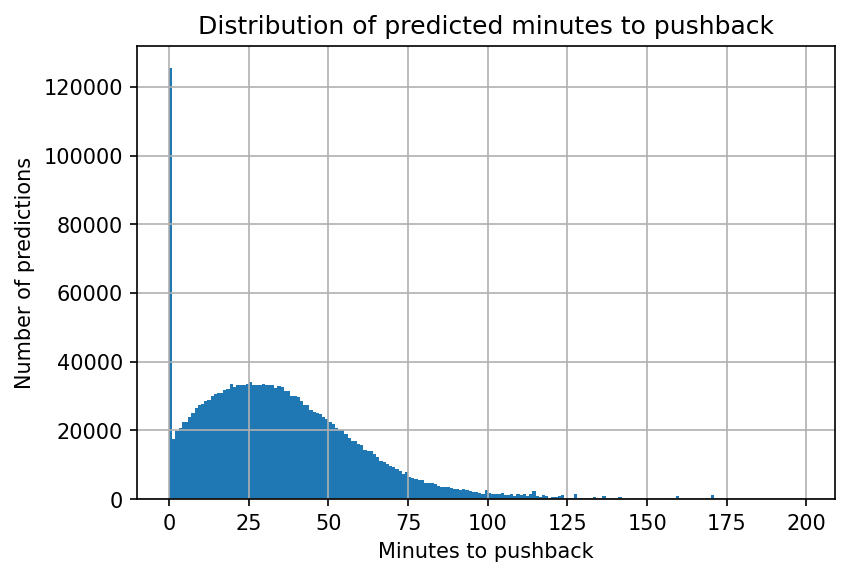

In [34]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
submission_format.minutes_until_pushback.clip(lower=0, upper=200).hist(bins=np.arange(0, 200), ax=ax)
ax.set_title("Distribution of predicted minutes to pushback")
ax.set_ylabel("Number of predictions")
ax.set_xlabel("Minutes to pushback")
_ = plt.show()

In [22]:
with pd.option_context("float_format", "{:.2f}".format):
    display(submission_format.minutes_until_pushback.describe())

count   2042723.00
mean         39.23
std          25.79
min         -14.00
25%          21.00
50%          36.00
75%          54.00
max         245.00
Name: minutes_until_pushback, dtype: float64

In [35]:
submission_format.to_csv("individual_model_timestamp_only.zip", index=False)